In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import Sequential, Input, Model
from keras.activations import relu
from keras.layers import Dense,Dropout
from keras import utils
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.callbacks import EarlyStopping
import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing  import MinMaxScaler, StandardScaler, RobustScaler, normalize


In [25]:
from keras.callbacks import History

In [26]:
def load_data(path_db: str) -> pd.DataFrame:
    df = pd.read_csv(path_db, delimiter=";", na_values="n/d")
    df["FECHA"] = pd.to_datetime(df["FECHA"], format="%d/%m/%y")
    df.set_index("FECHA", inplace=True)
    df.dropna(inplace=True)
    return df

In [27]:
def series_to_supervised(df: pd.DataFrame,
                         cols_names_inputs: list,
                         cols_names_outputs: list,
                         time_previous_input: int=0,
                         time_forecast_output: int=0) -> tuple[pd.DataFrame, pd.DataFrame]:

    # For inputs sequence (t-time_previous_input, ..., t-1).
    df_with_time_steps = pd.DataFrame()
    list_col_names_inputs = []
    for time_step in range(time_previous_input, 0, -1):
        for col_name in cols_names_inputs:
            new_col_name_input = '{}_t-{}'.format(col_name, time_step)
            df_with_time_steps[new_col_name_input] = df[col_name].shift(-time_step)
            list_col_names_inputs.append(new_col_name_input)

    # For outputs sequence (t, t+1, ..., t+time_forecast_output).
    list_col_names_outputs = []
    for time_step in range(time_forecast_output):
        for col_name in cols_names_outputs:
            new_col_name_output = '{}_t+{}'.format(col_name, time_step)
            df_with_time_steps[new_col_name_output] = df[col_name].shift(time_step)
            list_col_names_outputs.append(new_col_name_output)

    df_with_time_steps.dropna(inplace=True)
    return df_with_time_steps[list_col_names_inputs].copy(), df_with_time_steps[list_col_names_outputs].copy()

In [44]:
def build_mlp_model(numero_inputs: int,
                    numero_outputs,
                    numero_de_neuronas_capa_oculta: int,
                    function_activation: str,
                    uso_bias: bool,
                    num_hidden_layers:int=2) ->Model:
    
    input_layer = Input(shape=(numero_inputs,), name= "capa_entrada")
    x = Dense(units=numero_de_neuronas_capa_oculta,
                                    activation=function_activation,
                                    name="capa_oculta_1",
                                    use_bias=uso_bias)(input_layer)
    x = Dropout(rate=0.1)(x)

    for hidlayer in range (num_hidden_layers-1):

        x = Dense(units=numero_de_neuronas_capa_oculta,
                                        activation=function_activation,
                                        name="capa_oculta{}".format(hidlayer+1),
                                        use_bias=uso_bias)(x)
        x= Dropout(rate=0.1)(x)
    output_layer = Dense(units=numero_outputs, name="capa_salida")(x)

    model = Model(inputs=input_layer, outputs=output_layer)
   
    return model


In [29]:
def build_lstm_model(
                  numero_steps: int,
                  numero_features: int,
                  numero_de_neuronas_lstm_capa: int,
                  function_activation: str,
                  uso_bias: bool       # solo presente en las capas que no son LSTM
                 ) -> Model:           #numero_neuronas_lstm_capa debe mantenerse en todas las capas 
                                       #distintas del imput layer y del output layer. Lo que entra tiene que salir
   input_layer = Input(shape=(numero_inputs,numero_steps,numero_features), name= "capa_entrada") # OJO 3 dimensiones para las lstm inputs
   x = LSTM(units=numero_neuronas_lstm_capa,activation=function_activation, name="primera_capa_lstm")(input_layer)
   x = Dense(units=numero_neuronas_lstm_capa, activation=Function_activation, name="capa_oculta_1")(x)
   output_layer = Dense(units=numero_outputs, name="capa_salida")(x)

   model = Model(inputs=input_layer, outputs=output_layer)
   return model

In [30]:
def build_cnn_model() -> Model:
    input_layer = Input(shape=(numero_steps,numero_features,1), name='capa_entrada') # input son 3 dimensiones (ponemos 1 porq mi info tiene 2D) y.....
                                                                                     # falta una cuarta que son el numero de muestras pero que el modelo lo sobre entiende 
    x = Conv2D(filters=3, kernel_size=(2, 2), activation=function_activacion, name='capa_cnn_1')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    output_layer = Dense(units=numero_outputs, name='capa_salida')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [31]:
def build_cnn2D(number_of_inputs: int, number_of_channels: int = 1, n_filters: int=16, n_kernel: int=3, number_of_outputs: int =1) -> Model:
    input_layer = Input(shape=(number_of_inputs, number_of_channels, 1), name='inputlayer')
    x = Conv2D(filters=n_filters, kernel_size=(n_kernel, 1), activation='relu', name='conv1')(input_layer)
    x = MaxPooling2D(pool_size=(2, 1))(x)
    x = Flatten()(x)
    output_layer = Dense(units=number_of_outputs)(x)
    model = Model(input_layer, output_layer)

    return model

In [32]:
def build_cnn_multihead(number_of_inputs: int, number_of_channels: int = 1, n_filters: int=16, n_kernel: int=3, number_of_outputs: int =1) -> Model:
    # Create a channel for each variable.
    input_layers, output_layers = [], []
    for characteristic in range(number_of_channels):
        input_layer = Input(shape=(number_of_inputs, 1), name='inputlayer_{}'.format(characteristic))
        x = Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', name='conv1_{}'.format(characteristic))(input_layer)
        x = MaxPooling1D(pool_size=2)(x)
        out_flatten = Flatten()(x)

        # store layers.
        input_layers.append(input_layer)
        output_layers.append(out_flatten)

    # merge heads
    layers_concatenated = Concatenate()(output_layers)

    # interpretation.
    dense1 = Dense(200, activation='relu')(layers_concatenated)
    dense2 = Dense(100, activation='relu')(dense1)
    output_layer = Dense(number_of_outputs)(dense2)

    model = Model(inputs=input_layers, outputs=output_layer)

In [33]:
def fit_model(model: Model, train_dataset: tuple[np.ndarray, np.ndarray], val_dataset: tuple[np.ndarray, np.ndarray], epochs: int = 50) -> tuple[Model, History]:

    model.compile(optimizer='adam', loss='mse')
    history = model.fit(train_dataset[0],
                        train_dataset[1],
                        validation_data=val_dataset,
                        epochs=epochs)

    return model, history

In [34]:
def plot_training(history: History, name: str = '') -> None:
    epochs = history.epoch
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs, y=loss_train, mode='lines', name='loss_train' + name))
    fig.add_trace(go.Scatter(x=epochs, y=loss_val, mode='lines', name='loss_val' + name))
    fig.show()

In [39]:
def plot_results(history_object ,  title_plot: str):
    dict_resultado_historico = history_object.history

    x_values = history_object.epoch
    y_entrenamiento = dict_resultado_historico["loss"]
    y_validacion = dict_resultado_historico["val_loss"]

    plt.plot(x_values, y_entrenamiento, label="Entrenamiento", c="darkblue")
    plt.plot(x_values, y_validacion, label="validación" ,c="blue")

    plt.xlabel("Etapas")
    plt.ylabel("Error(loss)")
    plt.title("resultados")
    plt.legend
    plt.show

In [36]:
df_adra = load_data("./Data/adra.csv")

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 27.8094 - mae: 4.6267 - mape: 140.0415 - val_loss: 16.0187 - val_mae: 3.6613 - val_mape: 107.8346
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 20.1384 - mae: 3.8483 - mape: 115.0941 - val_loss: 10.2196 - val_mae: 2.8889 - val_mape: 83.5186
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 13.6682 - mae: 3.0827 - mape: 91.5277 - val_loss: 5.9037 - val_mae: 2.1455 - val_mape: 60.2890
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 9.1997 - mae: 2.4132 - mape: 70.9815 - val_loss: 2.9299 - val_mae: 1.4529 - val_mape: 39.7605
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.8681 - mae: 1.8608 - mape: 55.3645 - val_loss: 1.2321 - val_mae: 0.8802 - val_mape: 25.1402
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 3.9596 - mae: 1.4869 - mape: 45.9470 - val_loss: 0.5945 - val_mae: 0.5762 - val_mape: 20.9416
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 3.2816 - mae: 1.3595 - mape: 44

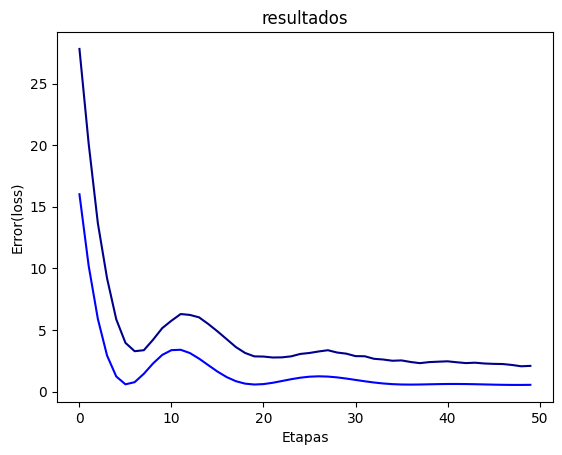

In [40]:
df_inputs, df_outputs = series_to_supervised(
    df_adra,
    ['Al10Rad'], 
    ["Al10ETo"],
    7,
    2)

###################################################
###########Univariate forecasting ones step########
###################################################
times_previous_input = 3
times_forecast_output = 1
col_names_inputs = ["Al10Rad"]
col_names_outputs = ["Al10ETo"]
df_inputs, df_outputs = series_to_supervised(
    df_adra,
    col_names_inputs,
    col_names_outputs,
    times_previous_input,
    times_forecast_output
)

# otra forma =df_train, df_val = train_test_split(pd.concat([df_inputs, df_outputs], axis=1), train_size=0.8, random_state=123) 
df_train_inputs, df_val_inputs, df_train_outputs, df_val_outputs = train_test_split(df_inputs, df_outputs, train_size=0.8, random_state=123) 


arr_train_inputs = df_train_inputs.to_numpy()
arr_train_outputs = df_train_outputs.to_numpy()
arr_val_inputs = df_val_inputs.to_numpy()
arr_val_outputs = df_val_outputs.to_numpy()


# decisiones en el proceso de modelado. Hiperparametros
numero_de_neuronas_capa_oculta= 60
function_activation="relu"
uso_bias = True
funcion_entrenamiento ="adam"
loss_funcion= "mse"
list_metrics = ["mae","mape"]
batch_size = 10000
numero_de_epocas = 50
numero_outputs = 1
numero_inputs = len(col_names_inputs) * times_previous_input



model = build_mlp_model(numero_inputs=numero_inputs,
                        numero_outputs=numero_outputs,
                        numero_de_neuronas_capa_oculta=numero_de_neuronas_capa_oculta,
                        function_activation=function_activation,
                        uso_bias=uso_bias,
)      

model.compile(optimizer=funcion_entrenamiento,
              loss=loss_funcion,
              metrics=list_metrics)




history_object =model.fit(
                    arr_train_inputs,
                    arr_train_outputs,
                    batch_size=batch_size,
                    validation_data=(arr_val_inputs, arr_val_outputs),
                    epochs=numero_de_epocas,
                    
)

plot_results(history_object ,  title_plot="ADRA")



In [46]:
#############################################
    ###    Multivariate forecasting, one step ###
    #############################################

numero_de_neuronas_capa_oculta= 60
function_activation="relu"
uso_bias = True
funcion_entrenamiento ="adam"
loss_funcion= "mse"
list_metrics = ["mae","mape"]
batch_size = 10000
numero_de_epocas = 50
numero_outputs = 1
numero_inputs = len(col_names_inputs) * times_previous_input
    # Model MLP
model_mlp_eto = build_mlp_model(number_of_inputs, number_of_ouputs)
model_eto_trained, history_results = fit_model(model_mlp_eto,
                                                   (train_inputs, train_outputs),
                                                   (val_inputs, val_outputs))
plot_training(history_results, '_mlp_multivariate_one_step')

    # Model LSTM
number_of_inputs = time_previous_inputs ## --> Importante esto con respot a mlp.
number_of_features = len(cols_names_inputs)  # --> Es univariate.
model_lstm_eto = build_lstm(number_of_inputs, number_of_features=number_of_features)

train_inputs_reshaped = train_inputs.reshape(train_inputs.shape[0], time_previous_inputs, number_of_features)
val_inputs_reshaped = val_inputs.reshape(val_inputs.shape[0], time_previous_inputs, number_of_features)

model_lstm_eto_trained, history_lstm_results = fit_model(model_lstm_eto,
                                                             (train_inputs_reshaped, train_outputs),
                                                             (val_inputs_reshaped, val_outputs))
plot_training(history_lstm_results, '_lstm_multivariate_one_step')

# Model CNN multichannel.
number_of_inputs = time_previous_inputs
number_of_channels = len(cols_names_inputs)
model_cnn_eto = build_cnn(number_of_inputs, number_of_channels=number_of_channels)

train_inputs_reshaped = train_inputs.reshape(train_inputs.shape[0], time_previous_inputs, number_of_channels)
val_inputs_reshaped = val_inputs.reshape(val_inputs.shape[0], time_previous_inputs, number_of_channels)

model_cnn_eto_trained, history_cnn_results = fit_model(model_cnn_eto,
                                                           (train_inputs_reshaped, train_outputs),
                                                           (val_inputs_reshaped, val_outputs))
plot_training(history_cnn_results, '_cnn_multichannel_multiariate_one_step')

# Model CNN 2D multichannel.
number_of_channels = len(cols_names_inputs)  # --> Es univariate.
model_cnn2d_eto = build_cnn2D(time_previous_inputs, number_of_channels=number_of_channels)

train_inputs_reshaped = train_inputs.reshape(train_inputs.shape[0], time_previous_inputs, number_of_channels, 1)
val_inputs_reshaped = val_inputs.reshape(val_inputs.shape[0], time_previous_inputs, number_of_channels, 1)

model_cnn2d_eto_trained, history_cnn2d_results = fit_model(model_cnn2d_eto,
                                                           (train_inputs_reshaped, train_outputs),
                                                           (val_inputs_reshaped, val_outputs))
plot_training(history_cnn2d_results, '_cnn_multichannel_multiariate_one_step')

# Model CNN multihead.
number_of_inputs = time_previous_inputs
number_of_channels = len(cols_names_inputs)
model_cnn_multihead_eto = build_cnn_multihead(number_of_inputs, number_of_channels=number_of_channels)
plot_model(model_cnn_multihead_eto, show_shapes=True, to_file='cnn_multiheaded.png')

train_inputs_reshaped = [train_inputs[:, chanel::number_of_channels].reshape(train_inputs.shape[0], time_previous_inputs, 1) for chanel in range(number_of_channels)]
val_inputs_reshaped = [val_inputs[:, chanel::number_of_channels].reshape(val_inputs.shape[0], time_previous_inputs, 1) for chanel in range(number_of_channels)]

model_cnn_multihead_eto_trained, history_cnn_multihead_results = fit_model(model_cnn_multihead_eto,
                                                           (train_inputs_reshaped, train_outputs),
                                                           (val_inputs_reshaped, val_outputs))

plot_training(history_cnn_multihead_results, '_cnn_multiheadl_multiariate_one_step')




    # model_cnn_multihead_eto_trained.save('model_cnn_multihead_eto_trained.keras')
    # loaded_model = load_model("model_cnn_multihead_eto_trained.keras")


NameError: name 'number_of_inputs' is not defined

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_entrada (InputLayer)       │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_1 (Dense)           │ (None, 60)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta1 (Dense)            │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_salida (Dense)             │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,961 (15.47 KB)

 Trainable params: 3,961 (15.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 19.9888 - mae: 3.8745 - mape: 116.9129 - val_loss: 10.9833 - val_mae: 3.0223 - val_mape: 88.6445
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 13.4260 - mae: 3.0712 - mape: 92.1726 - val_loss: 6.3392 - val_mae: 2.2365 - val_mape: 63.7056
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 8.5797 - mae: 2.3532 - mape: 70.3794 - val_loss: 3.1822 - val_mae: 1.5071 - val_mape: 41.7467
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 5.6529 - mae: 1.8277 - mape: 55.3245 - val_loss: 1.3802 - val_mae: 0.9107 - val_mape: 26.7565
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 3.7805 - mae: 1.4663 - mape: 46.0764 - val_loss: 0.7598 - val_mae: 0.6477 - val_mape: 23.8855
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 3.2273 - mae: 1.3683 - mape: 45.6628 - val_loss: 0.9961 - val_mae: 0.8018 - val_mape: 31.5419
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 3.5760 - mae: 1.4683 - mape: 50.008

<function matplotlib.pyplot.show(close=None, block=None)>

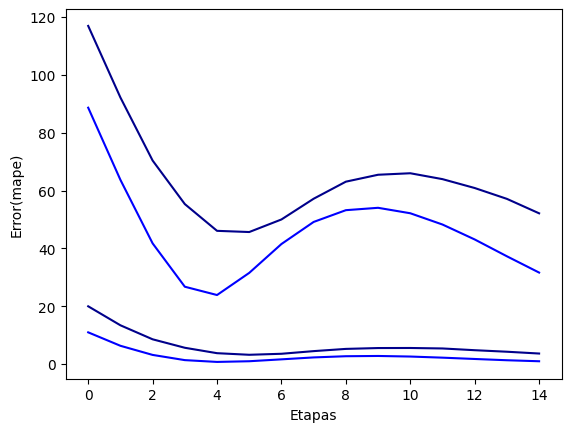

In [41]:
#Model
model = build_mlp_model(numero_inputs=numero_inputs,
                        numero_outputs=numero_outputs,
                        numero_de_neuronas_capa_oculta=numero_de_neuronas_capa_oculta,
                        function_activation=function_activation,
                        uso_bias=uso_bias,
)      
model.summary()

model.compile(optimizer=funcion_entrenamiento,
              loss=loss_funcion,
              metrics=list_metrics)


early_Stopping = EarlyStopping(monitor="val_loss", patience=10)
early_Stopping2 = EarlyStopping(monitor="val_mae", patience=30)

history_object =model.fit(
                    arr_train_inputs,
                    arr_train_outputs,
                    batch_size=batch_size,
                    validation_data=(arr_val_inputs, arr_val_outputs),
                    epochs=numero_de_epocas,
                    callbacks=[early_Stopping, early_Stopping2]

)

dict_resultado_historico = history_object.history

x_values = history_object.epoch
y_entrenamiento = dict_resultado_historico["loss"]
y_validacion = dict_resultado_historico["val_loss"]

plt.plot(x_values, y_entrenamiento, label="Entrenamiento", c="darkblue")
plt.plot(x_values, y_validacion, label="validación" ,c="blue")

plt.xlabel("Etapas")
plt.ylabel("Error(loss)")
plt.legend
plt.show


y_entrenamiento_mape = dict_resultado_historico["mape"]
y_validacion_mape = dict_resultado_historico["val_mape"]
plt.plot(x_values, y_entrenamiento_mape, label="Entrenamiento", c="darkblue")
plt.plot(x_values, y_validacion_mape, label="validación" ,c="blue")

plt.xlabel("Etapas")
plt.ylabel("Error(mape)")
plt.legend
plt.show